# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

<u>Данные находятся в файле</u> `/datasets/autos.csv.`

**Признаки**

- *DateCrawled* — дата скачивания анкеты из базы
- *VehicleType* — тип автомобильного кузова
- *RegistrationYear* — год регистрации автомобиля
- *Gearbox* — тип коробки передач
- *Power* — мощность (л. с.)
- *Model* — модель автомобиля
- *Kilometer* — пробег (км)
- *RegistrationMonth* — месяц регистрации автомобиля
- *FuelType* — тип топлива
- *Brand* — марка автомобиля
- *Repaired* — была машина в ремонте или нет
- *DateCreated* — дата создания анкеты
- *NumberOfPictures* — количество фотографий автомобиля
- *PostalCode* — почтовый индекс владельца анкеты (пользователя)
- *LastSeen* — дата последней активности пользователя

**Целевой признак**

- *Price* — цена (евро)

<div class style="border-radius: 7px; box-shadow: 3px 3px 1px; border: 2px solid ">
<h3>  Напоминание/ шпаргалки:<a class="tocSkip"></h3> 

- Чтобы усилить исследование, не будем ограничиваться только градиентным бустингом, попробуем более простые модели — иногда они работают лучше.   
- Поэкспериментируем и сравним характеристики моделей: время обучения, время предсказания, точность результата.   
- Для оценки качества моделей применим метрику **RMSE**.
- Значение метрики RMSE должно быть **меньше 2500**.
- Самостоятельно освоим библиотеку **LightGBM** и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой `%%timeit` или `%%time`.
- Модель градиентного бустинга может долго обучаться, поэтому изменять будем у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалить лишние переменные можно оператором `del`.    
</div>

## Подготовка данных

### Загрузим данные, путь к файлу: `/datasets/autos.csv`

In [ ]:
# Широкоформатный Jupyter
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# обновим версию sklearn
!pip install scikit-learn --upgrade

In [3]:
# Импортируем базы данных, которые пригодятся в нашем исследование

# импорты из стандартной библиотеки
import warnings
import re

# импорты сторонних библиотек
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from copy import deepcopy
from scipy import stats as st

!pip3 install prettytable
from prettytable import PrettyTable

!pip install category_encoders
import category_encoders as ce

# импорты модулей текущего проекта
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders.m_estimate import MEstimateEncoder
from sklearn.utils import shuffle
from numpy.random import RandomState
from sklearn.dummy import DummyRegressor



# настройка
# игнорируем ошибки matplotlib
warnings.filterwarnings("ignore")

# зафиксируем RandomState
STATE = np.random.RandomState(12345)

In [4]:
# Прочитаем файл и сохраним в датафрейм
autos = pd.read_csv('/datasets/autos.csv')

In [5]:
# посмотрим размер файла
autos.shape

(354369, 16)

В датафрейме у нас 354 369 строк и 16 столбцов/параметров.

### Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, удалим их.

In [6]:
# Создадим функцию для облегчения дальнейшего знакомства с данными
def information(data):

# Посмотрим основную информацию датафрейма
    display(data.info(), data.describe(include='all').T.round(2), data.head())

# Посмотрим кол-во дубликатов
    print('Кол-во дубликатов', data.duplicated().sum())
    print('')

# Проверим кол-во пропусков в столбцах датафрейма
# Сделаем функцию, которая возвращает таблицу с количеством и долей пропусков в датафрейме
    def isna_info(df):
        isna_count = df.isna().sum() # кол-во пропусков
        # дублируем столбец с пропущенными значениями и высчитываем процент, объединяем таблицы
        isna_table = (pd.concat([isna_count / df.shape[0], isna_count], axis=1,  keys=['percent', 'count'])
        # сортируем по убыванию, удаляем из таблцы непропущенные значения              
           .sort_values('percent', ascending=False)).loc[lambda x: x["count"] > 0]
        return isna_table
    print('Кол-во параметров с пропусками в столбцах:', len(isna_info(data)), '\n'), display(isna_info(data))
    
    # Построим общую гистограмму для всех столбцов таблицы
    data.hist(figsize=(15, 8))
    plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DateCrawled,354369,271174,2016-03-24 14:49:47,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,354369.0,NaN,NaN,NaN,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
VehicleType,316879,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,354369.0,NaN,NaN,NaN,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Gearbox,334536,2,manual,268251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,354369.0,NaN,NaN,NaN,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Model,334664,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,354369.0,NaN,NaN,NaN,128211.172535,37905.34153,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,NaN,NaN,NaN,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
FuelType,321474,7,petrol,216352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Кол-во дубликатов 4

Кол-во параметров с пропусками в столбцах: 5 



,percent,count
Repaired,0.200791,71154
VehicleType,0.105794,37490
FuelType,0.092827,32895
Gearbox,0.055967,19833
Model,0.055606,19705


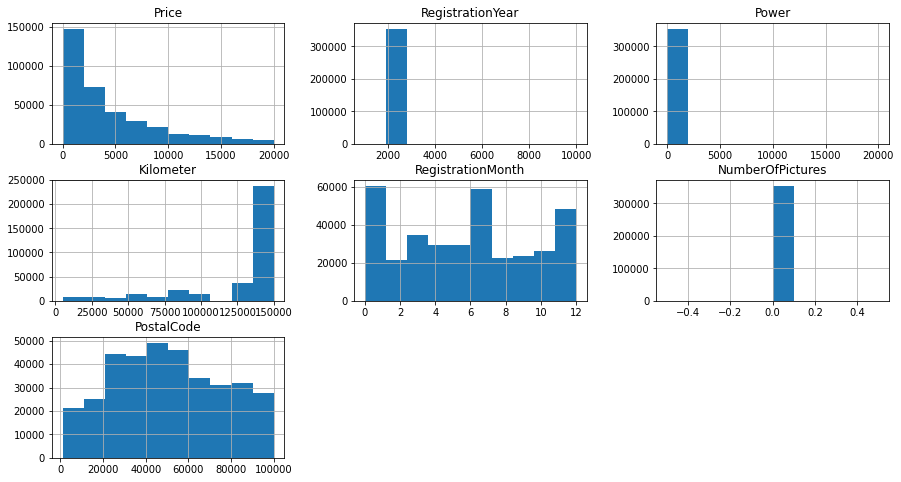

In [7]:
# Посмотрим информация по датасету
information(autos) 

Итак, в датафрейме более 350 анкет. Наименования столбцов не соблюдены по правилам написания кода PEP8, приведем их к нижнему регистру и разделим подчеркиванием. Нашли 4 явных дубликата, и присутствуют пропуски в 5 столбцах. Относительно типа данных: у нас 3 столбца ("DateCrawled", "DateCreated", "LastSeen ") отображают временной показатель, но при этом имеют тип данных "object", заменим его на "datetime64". Столбец "RegistrationMonth" в целочисленном формате, где "0" - Январь, а "11" - Декабрь. Столбец "Repaired" с типом данных "object" , в котором говорится, была машина в ремонте или нет (да/нет), можно перевести в формат "category", "bool" или "int" (заменив да\нет на 0\1).

**Категориальные признаки:**
- *VehicleType* (тип автомобильного кузова) - имеем 8 разновидностей, самый популярный тип - sedan; Около 10% данных по данному столбцу не заполнено.
- *Gearbox* (тип коробки передач) - 2 варианта: механика (самая популярная) или автомат. Теоретически можно заменить на целочисленный формат ("0" для механики / "1" для автомата) либо категориальный. Чуть больше 5% коробок передач не указано, что не есть хорошо, у того же самого популярного в данных анкетах "гольфа" может быть как механика, так и автомат;
- *Model* (модель автомобиля) - представлено 250 видов моделей. Очень много, при том, что 5% моделей не заполнены;
- *FuelType* (тип топлива) - 7 разновидностей, самая популярная - бензин. 7 разновидностей, как-то много, что может быть? бензин, дизель, газ, электроавтомобиль, гибрид, автомобили на водороде уже есть? Посмотрим признак подробнее, к тому же более 9% данных имеют пропуски;
- *Brand* (марка автомобиля) - 40 брендов. Самый популярный <img src="https://assets1.cbsnewsstatic.com/i/cbslocal/wp-content/uploads/sites/15909782/2014/02/volkswagen.jpg?w=1500" width=220 height=220 />, оно и не удивительно, судя по тому, что цены указаны в евро, Сервис по продаже автомобилей с пробегом «Не бит, не крашен» нацелен и работает в Европейском регионе. 
- *Repaired* (была машина в ремонте или нет) - про данный пункт мы уже говорили. Отметим, что самый "незаполненный" пункт, больше 20% данных по нему имеют пропуски. Владельцы просто забыли указать информацию? может не обратили внимание на пункт, потому что машина не была в ремонте ни разу? а может хотели скрыть таким образом дтп?.

<u><b>*Подытог по категориальным признакам:*<b></u> *для дальнейших исследований и построений моделей можно будет (даже необходимо) использовать "Encoding" (кодирование категориальных признаков), так что "изменение" типа данных в "Gearbox" и "Repaired" произойдет при "энкодинге". Над вариантом кодирования подумаем "ОНЕ" или что-то другое, смущает 250 видов моделей. Если пропущен и бренд, и модель автомобиля, возможно у сервиса «Не бит, не крашен», как и у "Авто.ру" (не реклама) предусмотрен раздел "Другое" для мало известных брендов и марок транспортного средства (теоретически подходит и только для графы моделей автомобиля)*
     
    
**Количественные признаки:**
 - *Price* (цена (евро)), <u>целевой признак</u> - Основной диапазон цены до 5000 евро. Очень много значений с ценой около нуля. Есть и анкеты с ценой 0 - выбросы? Сильное расхождение среднего показателя и медианны;
 - *RegistrationYear* (год регистрации автомобиля) - Масштаб графика превосходен :) Посмотрим признак отдельно. Видим, что есть выбросы - машины "выпущенные" в 1000 и 9999 годах;
 - *Power* (мощность (л. с.)) - аналогичная ситуация, как и с годом регистрации. Присутствуют некорректные значения - мощность в 0 л.с. или в 20 тысяч л.с. (хотя вдруг это какой-то небольшой самолет или судно);
 - *Kilometer* (пробег (км)) - у большей части автомобилей пробег достигает 150 тыс. км., при этом и максимальное значение равно 150 тыс. км. Кажется, на сайте покупатель не сам вводит пробег, а указывает категорию с шагом в 25 000 (судя по значениям графика и "describe") в которую попадает его автомобиль. Посмотрим подробнее - возможно, даже удобнее будет изменить тип данных на категориальный;
 - *RegistrationMonth* (месяц регистрации автомобиля) - больше всего регистраций происходит зимой и в середине лета. Минимальное значение - 0, максимальное - 12, странно, месяцев у нас 12, а значений 13. Как таковой пользы для дальнейших вычислений от одного месяца регистрации автомобиля нет, можно будет объединить с годом регистрации;
 - *NumberOfPictures* (количество фотографий автомобиля) - ноль, абсолютный ноль во всем. Какой-либо существенной информации данный столбец не несет, удалим его, так как восстановить кол-во фотографий нет возможности;
 - *PostalCode* (почтовый индекс владельца анкеты (пользователя)) - теоретически это не количественный признак, ~~а уникальный идентификатор клиента. По данному признаку мы можем узнать сколько автомобилей продает тот или иной клиент, так понять - физическое это лицо или какая-та организация, но влияет ли это на целевой признак - цену? Если организация из-за кол-ва и объемов продаж держит более низкую цену? Нужен ли в дальнейшем нам этот столбец?~~ а категориальный признак, идентификатор местоположения продажи автомобиля.

In [8]:
# Для удобства работать будем в копии базы, что бы всегда можно что-то сравнить с оригиналом
data = deepcopy(autos)

# выведем на экран названия столбцов
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [9]:
# Переименуем столбцы по правилам написания кода PEP8
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]
list(data.columns)

['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'repaired',
 'date_created',
 'number_of_pictures',
 'postal_code',
 'last_seen']

In [10]:
# Посмотрим на задублированные строки, отсортировав по целевому признаку

data[data.duplicated()].sort_values(by='price', ascending=False).head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21


In [11]:
# Удалим явные дубликаты
data = data.drop_duplicates().reset_index(drop=True)

data.duplicated().sum()

0

In [12]:
# Заменим тип данных в столбцах 
def type_replacement(column, data_type):
    data[column] = data[column].astype(data_type)
    # Посмотрим
    print(data[column].dtypes)

type_replacement(['date_crawled', 'date_created', 'last_seen'], 'datetime64[ns]')

date_crawled    datetime64[ns]
date_created    datetime64[ns]
last_seen       datetime64[ns]
dtype: object


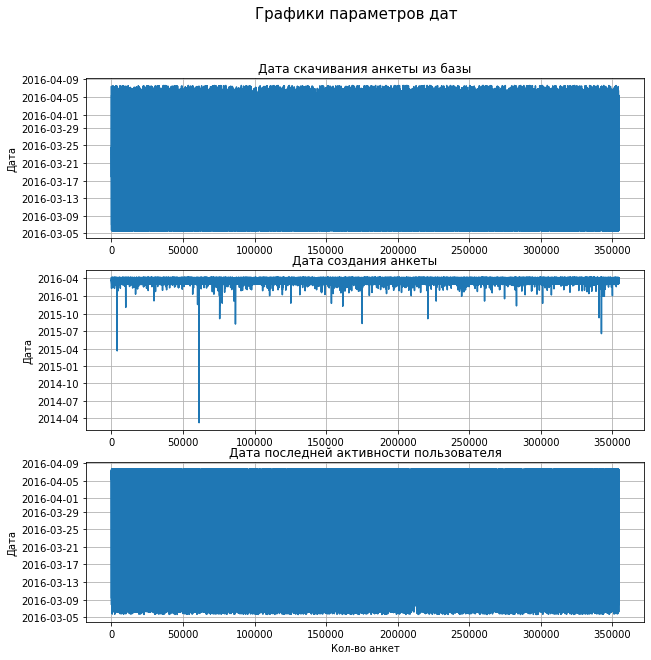

In [13]:
# посмотрим на информацию по столбцам с датами
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
fig.suptitle('Графики параметров дат', fontsize=15)
plt.xlabel('Кол-во анкет')

data['date_crawled'].plot(ax=axes[0], grid = True, title='Дата скачивания анкеты из базы')
axes[0].set_ylabel('Дата')
data['date_created'].plot(ax=axes[1], grid = True, title='Дата создания анкеты')
axes[1].set_ylabel('Дата')
data['last_seen'].plot(ax=axes[2], grid = True, title='Дата последней активности пользователя')
axes[2].set_ylabel('Дата')
plt.show()

- Анкеты равномерно скачивали из базы в течение месяца (период с 05 марта по ~ 09 апреля). Теоретически дата скачивания анкеты не влияет на целевой признак.
- Большую часть анкет создали в период с января 2016 по апрель 2016. Посмотрим на ранне созданные анкеты, возможно из-за того, что они долго "провисели" на сайте, автомобили там мало ликвидны и цена у них ниже.
- Дата последней активности совпадает с датой скачивания

In [14]:
# посмотрим на колв-о анкет до 2016 года
print(len(data.loc[data['date_created'] < '2016-01-01']))
data.loc[data['date_created'] < '2016-01-01'].sort_values(by='date_created')

26


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
61207,2016-03-16 11:48:06,8999,NaN,2005,NaN,0,147,125000,0,petrol,alfa_romeo,NaN,2014-03-10,0,79669,2016-04-07 04:46:24
4001,2016-03-23 14:42:46,6000,bus,1995,auto,200,other,150000,0,petrol,chevrolet,no,2015-03-20,0,24558,2016-04-07 03:45:01
342271,2016-03-05 21:44:26,10400,bus,1993,NaN,0,ducato,30000,1,gasoline,fiat,NaN,2015-06-18,0,76275,2016-04-05 17:46:09
86601,2016-04-02 19:47:40,14250,convertible,2005,manual,163,slk,150000,6,petrol,mercedes_benz,no,2015-08-07,0,76228,2016-04-07 09:15:23
175102,2016-03-08 17:57:45,5200,convertible,2006,manual,109,2_reihe,80000,11,petrol,peugeot,no,2015-08-10,0,26382,2016-04-05 20:46:54
75598,2016-03-14 08:43:53,600,small,2005,manual,54,polo,150000,1,petrol,volkswagen,yes,2015-09-04,0,72669,2016-03-15 14:16:58
221001,2016-03-15 01:56:49,600,small,2005,manual,54,polo,150000,1,petrol,volkswagen,yes,2015-09-04,0,72669,2016-03-15 15:49:29
340612,2016-03-05 21:51:02,9500,small,2013,manual,90,corsa,50000,4,gasoline,opel,no,2015-09-09,0,98739,2016-04-05 17:46:04
9972,2016-03-05 17:53:53,3490,sedan,2006,manual,88,clio,150000,3,petrol,renault,no,2015-11-02,0,40880,2016-03-17 15:46:57
161567,2016-03-05 14:31:01,15500,wagon,2009,manual,160,a4,100000,11,petrol,audi,no,2015-11-08,0,56410,2016-04-06 23:15:36


У нас есть 26 анкет, созданных до 2016 года, в которых в большей мере все столбцы заполнены (целевой признак заполнен везде). Всего 1 объявление размещено в 2014 году.

Таким образом мы можем предположить следующее: 
- Если даже дата активности клиента была позднее, чем дата скачивания анкеты, то клиент уже не сможет поменять цену или какую-то другую информацию о авто, т.к. анкета уже скачена из базы, следоватлеьно данный столбец нам полезной информации дать не может;
- Данные о скачивание анкеты находятся в узком диапазоне, скорее такая информация больше запутает модель обучения, к тому же если были внесены изменения в анкету, то "финальная" версия анкеты и была скачена, следовательно данный столбец тоже нас не интересует;
- Информация о создании анкеты тоже никаких "плюсов" в модель не привнесет, т.к. после создания модели обучения, новые анкеты будут поступать с совершенно другой датой создания анкеты.

Выходит, данные <u>столбцы мы можем удалить</u>. На будущее запомним, что дата регистрации автомобиля **не может превышать дату** скачивания анкеты, т.е. **04.2016**

In [15]:
# Удалим "лишние" столбцы, не забываем про "кол-во фотографий"
data = data.drop(['date_crawled', 'date_created', 'last_seen', 'number_of_pictures'], axis =1)
print(data.shape)
print('')
data.head()

(354365, 12)



,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437


Для понимания дальнейшей обработки посмотрим детальнее на распределения

In [16]:
# Посмотрим кол-во тех или иных значений в столбцах, отсортировав по убыванию
# сделаем функцию для вывода уникальных значений
def unique_values(value_column):
    for column in data[value_column]:
        print('Значения столбца ', column, 'и кол-во уникальных значений', data[column].nunique())
        print('')
        print(data[column].value_counts(ascending=False, dropna=False))
        print('')

In [17]:
# Смотрим что с почтовым индексом       
print(unique_values(['postal_code']))
# и на статистические данные
data['postal_code'].describe()

Значения столбца  postal_code и кол-во уникальных значений 8143

10115    819
65428    613
66333    343
32257    317
44145    317
        ... 
21782      1
9517       1
29367      1
38325      1
82404      1
Name: postal_code, Length: 8143, dtype: int64

None


count    354365.000000
mean      50508.503800
std       25783.100078
min        1067.000000
25%       30165.000000
50%       49413.000000
75%       71083.000000
max       99998.000000
Name: postal_code, dtype: float64

В почтовом индексе аномальных значений нет, столбец оставляем в исходном состояние, для понимания ценообразования в зависимости от географии.

In [21]:
data = data.drop('postal_code', axis=1)
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [22]:
# Посмотрим на пробег       
print(unique_values(['kilometer']))

Значения столбца  kilometer и кол-во уникальных значений 13

150000    238207
125000     36453
100000     14882
90000      11567
80000      10047
70000       8593
60000       7444
5000        6397
50000       6232
40000       4911
30000       4436
20000       3974
10000       1222
Name: kilometer, dtype: int64

None


count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


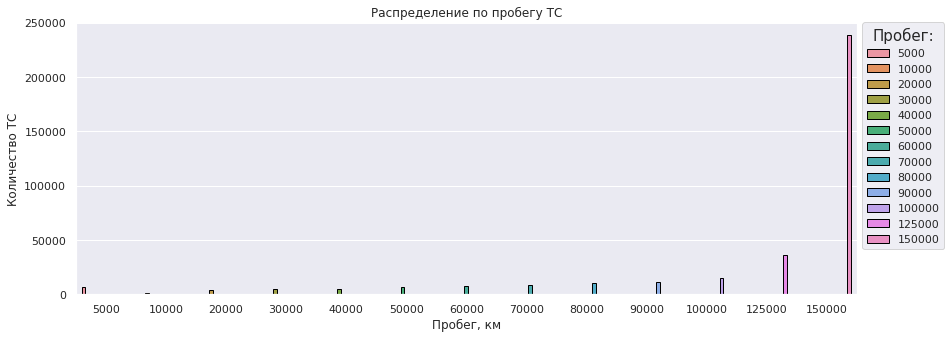

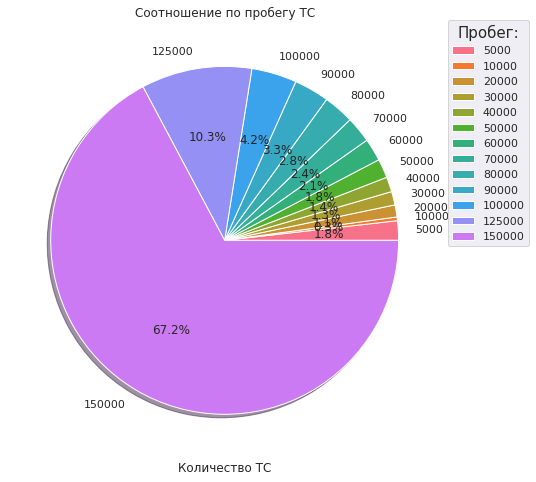

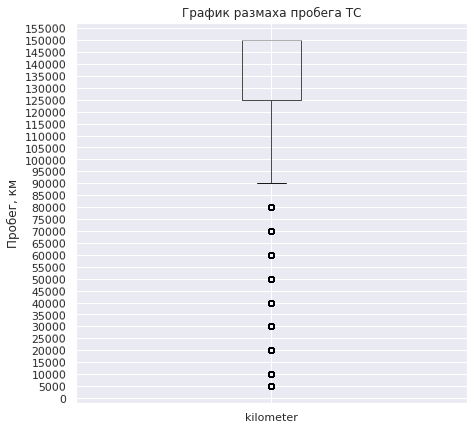

In [23]:
# Посмотрим на распределение 

#  Посмотрим на статистические данные столбца, которые дают представление о распределение значений
print(data['kilometer'].describe())

# Посмотрим на столбчатый график 
sns.set(rc={'figure.figsize':(14,5)})
sns.countplot(data=data, x='kilometer', ec='black', hue='kilometer')
plt.title('Распределение по пробегу ТС')
plt.xlabel('Пробег, км')
plt.ylabel('Количество ТС')
# plt.yticks(ticks=np.arange(0,2001,100))
legend = plt.legend(title = "Пробег:",
                     title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

# Посмотрим на круговую диаграмму
colors = sns.color_palette("husl", 15)
data.groupby(['kilometer']).count().plot(kind='pie', y='price', figsize=(8, 8),
  autopct='%0.01f%%', colors=colors, shadow=True)
plt.title('Соотношение по пробегу ТС')
plt.xlabel('Количество ТС')
plt.ylabel('')
legend = plt.legend(title = "Пробег:",
                     title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

# график размаха
data.boxplot(column = 'kilometer', figsize=(7,7))
plt.title('График размаха пробега ТС')
plt.yticks(ticks=np.arange(0,160000,5000), rotation=1)
plt.ylabel('Пробег, км')
plt.show()

Параметр "пробег" разбит на 13 частей: 
- с 0 до 5 000 км;
- с 5 000 до 10 000 км;
- далее с шагом 10 000 км до пробега в 100 000 км;
- далее шаг 25 000 км до пробега в 150 000 км.

У большей части автомобилей, около 67%, пробег превышает 100 000 км, а если смотреть по графику с усами, то пробеги от 80 000 и менее, можно считать выбивающимися значениями.

In [24]:
# Смотрим что с регистрацией ТС       
print(unique_values(['registration_month', 'registration_year']))

Значения столбца  registration_month и кол-во уникальных значений 13

0     37352
3     34373
6     31507
4     29270
5     29153
7     27211
10    26099
12    24289
11    24186
9     23813
1     23218
8     22627
2     21267
Name: registration_month, dtype: int64

Значения столбца  registration_year и кол-во уникальных значений 151

2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: registration_year, Length: 151, dtype: int64

None


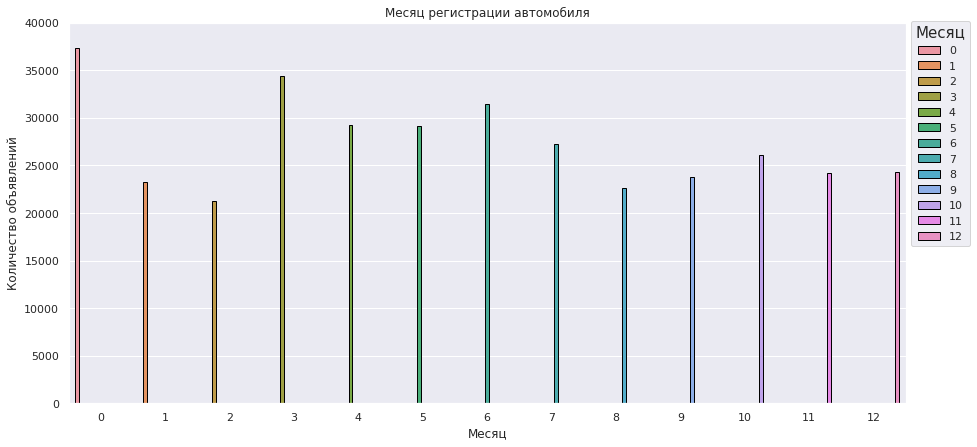

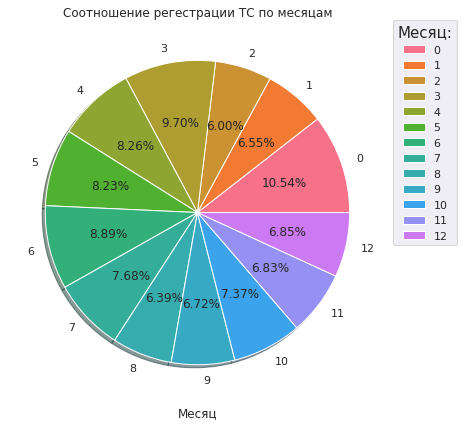

In [25]:
# Как мы видим, месяцев у нас 13, а в годе выпуска присутсвует далекое будущее и прошлое 

# registration_month

# Посмотрим на столбчатый график 
sns.set(rc={'figure.figsize':(15,7)})
sns.countplot(data=data, x='registration_month', ec='black', hue='registration_month')
plt.title('Месяц регистрации автомобиля')
plt.xlabel('Месяц')
plt.ylabel('Количество объявлений')
plt.yticks(ticks=np.arange(0,45000,5000))
legend = plt.legend(title = "Месяц",
                      title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

# Посмотрим на круговую диаграмму
colors = sns.color_palette("husl", 15)
data.groupby(['registration_month']).count().plot(kind='pie', y='price', autopct='%.2f%%', colors=colors, shadow=True)
plt.title('Соотношение регестрации ТС по месяцам')
plt.xlabel('Месяц')
plt.ylabel('')
legend = plt.legend(title = "Месяц:",
                      title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

Отлично, у нас получается **13** месяцев регистрации ТС, которые плюс минус нормально распределены от ~ 6% до 10,5% данных приходится на каждый месяц.
Кажется идею объединения столбцов "месяц регистрации" и "год регистрации" в один отменяем, т.к. корректность индефицирования месяца при таком распределении выявить трудно. Возможно столбец придется удалить, что бы в дальнейшем "не запутать" модель обучения.

In [26]:
# Удаляем столбец
data = data.drop('registration_month', axis =1)
print(data.shape)
print('')
data.head()

(354365, 10)



,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64


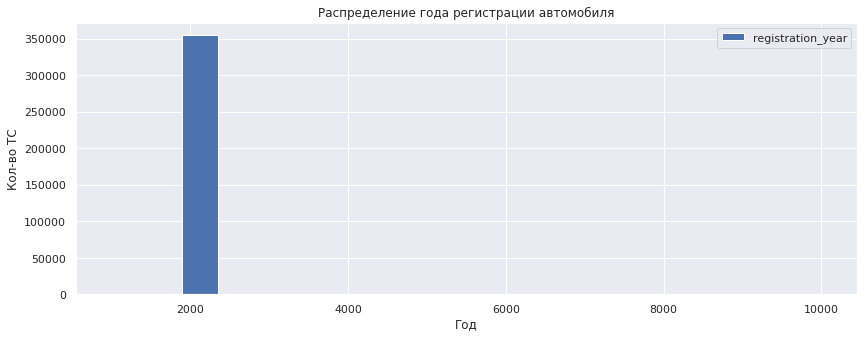

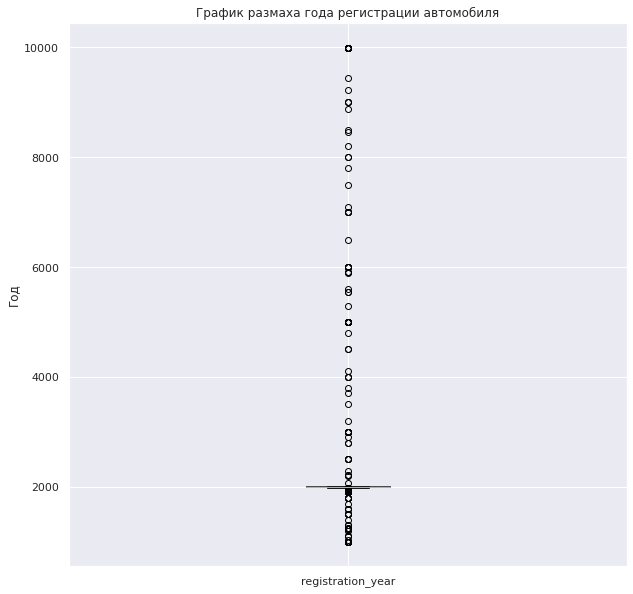

In [27]:
# registration_year

#  Посмотрим на статистические данные столбца, которые дают представление о распределение значений
print(data['registration_year'].describe())

# гистограмма
data.plot(kind='hist', y='registration_year', bins=20, grid=True, figsize=(14, 5))
plt.title('Распределение года регистрации автомобиля')
plt.xlabel('Год')
#plt.xticks(ticks=np.arange(1930,2024,1), rotation=1)
plt.ylabel('Кол-во ТС')
plt.show()

# график размаха
data.boxplot(column = 'registration_year', figsize=(10,10))
plt.title('График размаха года регистрации автомобиля')
#plt.yticks(ticks=np.arange(1930,2024,1), rotation=1)
plt.ylabel('Год')
plt.show()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64


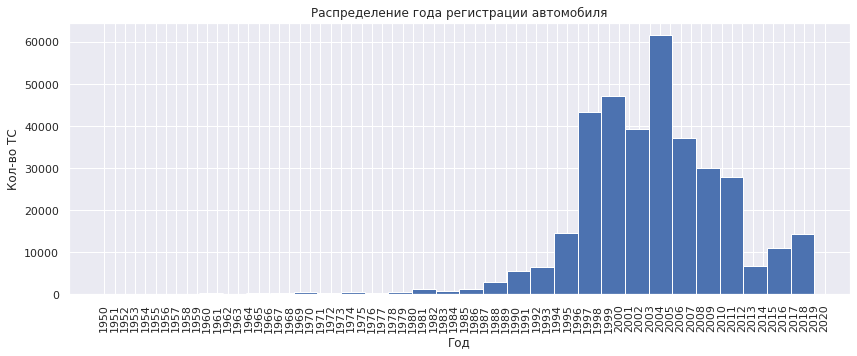

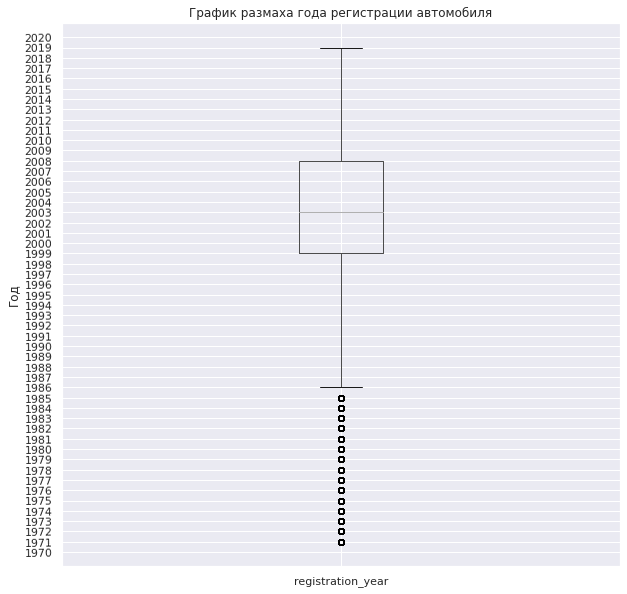

In [28]:
# registration_year (Попытка номер 2, изобретая велосипед)
# возьмем распределение начиная с 1950 года ( вероятность в продаже машины 1930 года весьма мала), остальные значения будем считать единичными

#  Посмотрим на статистические данные столбца, которые дают представление о распределение значений
print(data['registration_year'].describe())

# гистограмма
data.loc[(data['registration_year'] > 1949) & (data['registration_year'] < 2020), 'registration_year'].plot(kind='hist',
                y='registration_year', bins=30, grid=True, figsize=(14, 5))
plt.title('Распределение года регистрации автомобиля')
plt.xlabel('Год')
plt.xticks(ticks=np.arange(1950,2021,1), rotation=90)
plt.ylabel('Кол-во ТС')
plt.show()

# график размаха
# boxplot выдает ошибку на pd.Series, переведем в DataFrame
pd.DataFrame(data.loc[(data['registration_year'] > 1970) & (data['registration_year'] < 2020), 'registration_year']).boxplot(figsize=(10,10))
plt.title('График размаха года регистрации автомобиля')
plt.yticks(ticks=np.arange(1970,2021,1), rotation=1)
plt.ylabel('Год')
plt.show()

2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
2003    19762
2004    19611
2002    19091
1998    17899
2007    17183
2008    15391
1997    14666
2009    14503
1996    10835
2010    10764
2017    10441
2011     9909
1995     9607
2016     9599
2012     7178
Name: registration_year, dtype: int64


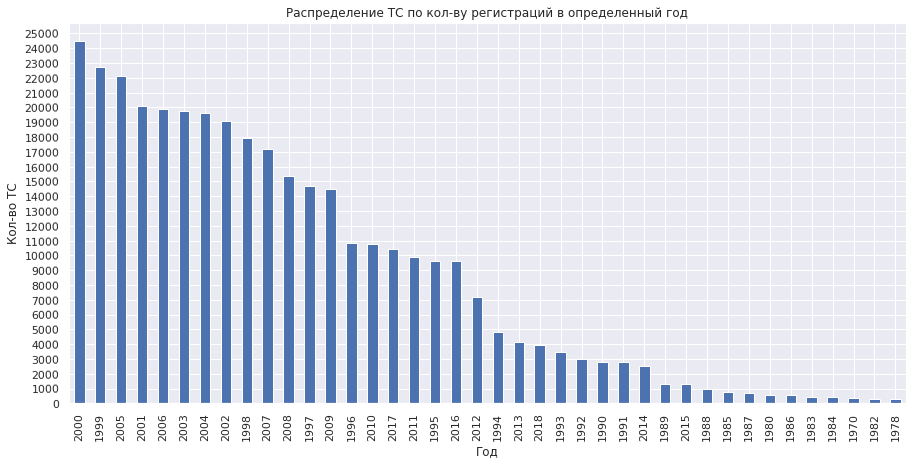

In [29]:
# Посмотрим на первую 20ку ТС по кол-ву регистраций в определенный год
print(data['registration_year'].value_counts().head(20))

# Посмотрим на распределение ТС по кол-ву регистраций в определенный год
data['registration_year'].value_counts().head(40).plot.bar()
plt.title('Распределение ТС по кол-ву регистраций в определенный год')
plt.yticks(ticks=np.arange(0,25001,1000), rotation=1)
plt.xlabel('Год')
plt.ylabel('Кол-во ТС')
plt.show()

Статистическое распределение, гистограмма и боксплот говорят нам о том, что медиана зарегистрированных ТС приходится на 2003 год, а plot.bar показывает, что 2003 год по кол-ву регистраций находится только на 6 месте, больше всего зарегистрировано в 2000 году - 24490 автомобиля. Основной диапазон регистрации начинается с конца 90х годов, неудивительно, производство и продажа машин растет в геометрической прогрессии. Так же мы видим огромное кол-во выбивающихся и некорректно указанных значений. Разберемся с ними.

In [30]:
# посмотрим на кол-во объявлений с регистраций ТС до 49 года и после 2016 (что не возможно, помним про даты анкет же)
print('Кол-во ТС "зарегестрированных" после 2018 года: ', data.loc[data['registration_year'] > 2016, 'registration_year'].count())
print('Кол-во ТС "зарегестрированных" до 1970 года: ', data.loc[data['registration_year'] < 1970, 'registration_year'].count())

Кол-во ТС "зарегестрированных" после 2018 года:  14530
Кол-во ТС "зарегестрированных" до 1970 года:  1338


Как видим, количество таких объявлений минимально в сравнение с общим объемом данных. Из-за того, что корректно год регистрации восстановить не удастся, потому что бренды выпускают определенные модели в целом не один год, при этом и коробка передач и количество л.с. может не меняться, то такие данные мы удалим. Нижняя граница боксплота находится на 1986 году, но удалим по 70 года, так как если данные заполнены корректны, то у нас будет более полная картина рынка. Есть конечно модели и младше 1970 года в продаже, но скорее это раритетные / коллекционные модели, которые продаются по другим правилам, либо же нелеквид. 

In [31]:
# уменьшаем датафрейм
data = data[(data['registration_year'] >= 1970) & (data['registration_year'] <= 2016)]
data.shape

(338497, 10)

Значения столбца  price и кол-во уникальных значений 3690

0       9858
500     5454
1500    5085
1000    4353
1200    4327
        ... 
6208       1
4782       1
6575       1
2221       1
8188       1
Name: price, Length: 3690, dtype: int64

None
count    338497.000000
mean       4461.741433
std        4536.382895
min           0.000000
25%        1099.000000
50%        2799.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64


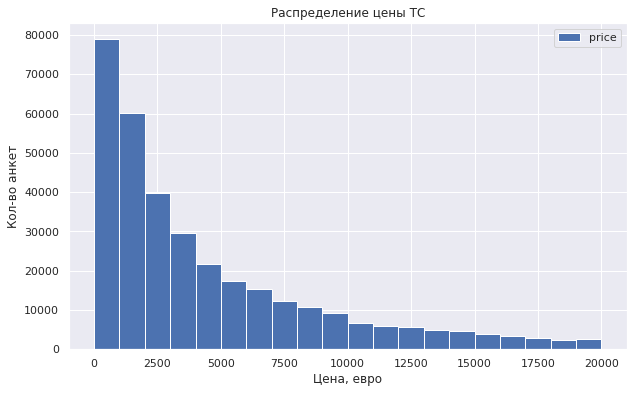

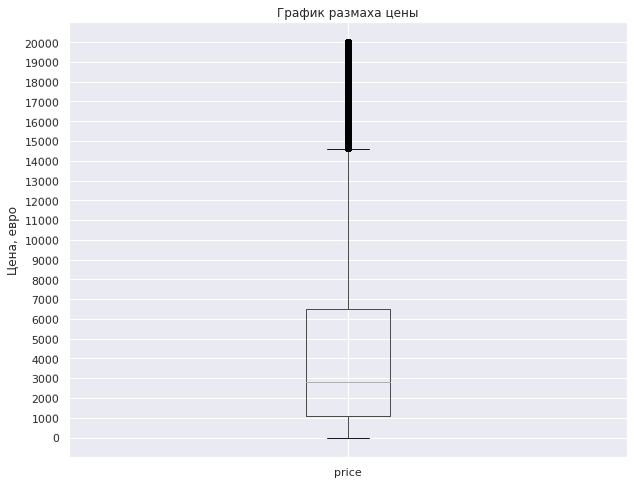

In [32]:
# Посмотрим на целевой признак       
print(unique_values(['price']))

#  Посмотрим на статистические данные
print(data['price'].describe())

# гистограмма
data.plot(kind='hist', y='price', bins=20, grid=True, figsize=(10, 6))
plt.title('Распределение цены ТС')
plt.xlabel('Цена, евро')
plt.ylabel('Кол-во анкет')
plt.show()

# график размаха
data.boxplot(column = 'price', figsize=(10,8))
plt.title('График размаха цены')
plt.yticks(ticks=np.arange(0,21000,1000), rotation=1)
plt.ylabel('Цена, евро')
plt.show()

По целевому признаку видим, что около 10000 анкет имеют цену 0 евро. Из-за этого у нас идет расхождение между средним значением (4461 евро) и медианным (2799). Распределение цены линейно-отрицательное, чем больше цена, тем меньше объявлений. 

Объявления с ценой в 0 евро удалим. Хоть 10 тыс объявлений и много, и мы и можем подобрать значение цены по средней, медиане или моде для определенных моделей с определенным пробегом, коробкой передач, типом кузовом, годом выпуска и т.д., но цена - целевой признак, и было бы некорректно подбирать ее вручную, это задача нашей модели.

In [33]:
# уменьшаем выборку
data = data[data['price'] != 0]
data.shape

(328639, 10)

Границы первого квартиля 1200.0


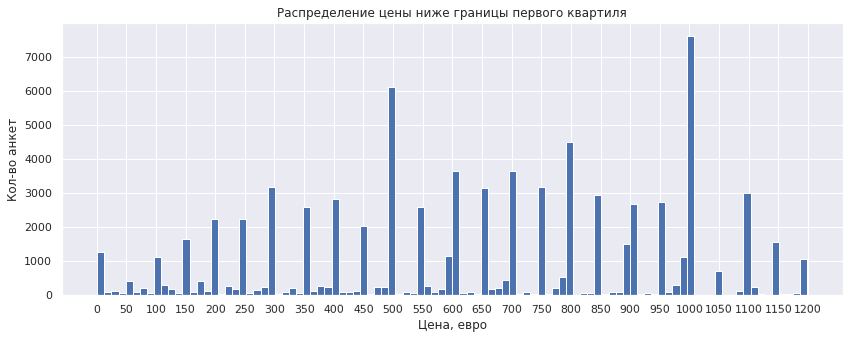

In [34]:
# Посчитаем границы усов боксплота
price_quantiles = data['price'].quantile([0.25, 0.5, 0.75])
price_q1 = price_quantiles[0.25]
print(f'Границы первого квартиля {price_q1}')

# проверяем распределение данных о цене ниже границы первого квартиля
plt.figure(figsize=(14, 5)) 
data[data['price'] < data['price'].quantile(0.25)]['price'].hist(bins = 100)
plt.title('Распределение цены ниже границы первого квартиля')
plt.xlabel('Цена, евро')
plt.xticks(ticks=np.arange(0,1250,50), rotation=1)
plt.ylabel('Кол-во анкет')
plt.show()

Как видим, машины с ценой 500 являются "психологической" отметкой для объявлений в диапозоне ниже границы первого квартиля - таких объявлений в 2 раза больше, чем более маленьких цен. Удалим объявлений ниже этой цены, потому что такие цены малы даже для "неликвида".

In [35]:
# уменьшаем выборку
data = data[data['price'] >= 500]
data.shape

(304220, 10)

In [36]:
# Посмотрим на модели брендов     
print(unique_values(['model']))

Значения столбца  model и кол-во уникальных значений 250

golf                  24767
other                 21056
3er                   17966
NaN                   12598
polo                  10091
                      ...  
elefantino                4
rangerover                3
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: model, Length: 251, dtype: int64

None


12 тысяч пропущенных значений. К сожалению как-то идентифицировать модели у бренда трудно, располагая только данными о кол-ве л.с., типу топливе и кузова. Так что заменим все незаполненные значения на "unidentified". Имеющуюся модель "other" будем считать редикими моделями

У нас есть модель "3er", скорее всего бмв, которая занимает 3 место по кол-ву объявлений (третья модель и 3 место :)). И есть модель "serie_3", скорее всего тоже бмв, и та же модель. Посмотрим на дубликаты названий моделей.

In [37]:
# земеняем
data['model'] = data['model'].fillna('unidentified')
print('Кол-во пропущенных моделей:', data['model'].isna().sum())
print('')

# посмотрим на уникальные наименования
data['model'].unique()

Кол-во пропущенных моделей: 0



array(['unidentified', 'grand', 'golf', 'fabia', '3er', '2_reihe',
       'c_max', '3_reihe', 'passat', 'navara', 'twingo', 'a_klasse',
       'scirocco', '5er', 'other', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo', '1er',
       'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'polo', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', 'escort', 'forester',
       'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo', 'focus',
       'tt', 'a6', 'jazz', 'slk', '7er', '80', '147', 'z_reihe',
       'sorento', 'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'ka',
       'almera', 'megane', 'lupo', 'caddy', 'mondeo', 'cordoba', 'colt',
       'impreza', 'corsa', 'vectra', 'berlingo', 'tiguan', 'sharan',
       '6_reihe', 'c4', 'panda', 'up', 'i_reihe', 'ceed', '5_reihe',
       'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus',
       'fox', 'matiz', 'beetle', 'c1', 'rio', 'touareg', 'logan',
       'spider', 'omega',

In [38]:
# посмотрим на модели N-ого ряда
data[data['model'].str.contains("reihe")].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
85,8000,suv,2005,manual,185,xc_reihe,150000,gasoline,volvo,NaN
148,800,sedan,2004,manual,88,3_reihe,150000,petrol,peugeot,yes
153,9450,convertible,2004,manual,170,z_reihe,150000,petrol,bmw,no


'3_reihe' и мазда и пежо...

In [39]:
# Посмотрим в каком бренде какие модели

# выведем список брендов
list_brand = list(data['brand'].unique())

# сделаем еще список, в которой будут добавляться списки моделей брендов, для дальнейшего сравнения
brand_list = []

# делаем цикл, которой создает список моделей для каждого бренда
for brand in list_brand:
    # список моделей по бренду
    brand_models = data[data['brand'] == brand]['model'].unique()
    # присваиваем название этому списку по названию бренда 
    exec(f'{brand}_models = brand_models')
    #добавляем в список
    brand_list.append('{}_models'.format(brand))
    # выводим на экран
    print(f'Модели {brand}:')
    print(data[data['brand'] == brand]['model'].unique())
    print('')

Модели audi:
['unidentified' 'a8' 'a4' 'a1' 'tt' 'a6' '80' 'a3' 'a2' 'a5' 'other' '90'
 '100' 'q7' 'q3' '200' 'q5']

Модели jeep:
['grand' 'wrangler' 'cherokee' 'other' 'unidentified']

Модели volkswagen:
['golf' 'passat' 'scirocco' 'transporter' 'other' 'jetta' 'polo'
 'unidentified' 'eos' 'touran' 'lupo' 'caddy' 'tiguan' 'sharan' 'up' 'fox'
 'beetle' 'touareg' 'kaefer' 'phaeton' 'cc' 'bora' 'amarok']

Модели skoda:
['fabia' 'yeti' 'octavia' 'roomster' 'other' 'superb' 'unidentified'
 'citigo']

Модели bmw:
['3er' '5er' '1er' '7er' 'z_reihe' 'unidentified' '6er' 'x_reihe' 'other'
 'm_reihe' 'i3']

Модели peugeot:
['2_reihe' '3_reihe' 'unidentified' 'other' '4_reihe' '1_reihe' '5_reihe']

Модели ford:
['c_max' 'fiesta' 'escort' 'focus' 'mustang' 'ka' 'mondeo' 's_max'
 'galaxy' 'other' 'transit' 'unidentified' 'fusion' 'kuga' 'b_max']

Модели mazda:
['3_reihe' 'other' '6_reihe' '5_reihe' 'rx_reihe' '1_reihe' 'mx_reihe'
 'cx_reihe' 'unidentified']

Модели nissan:
['navara' 'micra' 'almer

In [40]:
brand_intersections = []
brand_intersection = set(mazda_models).intersection(set(peugeot_models))
brand_intersections.append(brand_intersection)

print(brand_intersections)

[{'5_reihe', '3_reihe', 'other', 'unidentified', '1_reihe'}]


Видим пересечение наименований моделей у "пежо" и "мазды". Переименуем их.

In [42]:
# меняем
data.loc[(data['brand'] == "mazda") & (data['model'] == "1_reihe"), 'model'] = "1er_reihe"
data.loc[(data['brand'] == "mazda") & (data['model'] == "3_reihe"), 'model'] = "3er_reihe"
data.loc[(data['brand'] == "mazda") & (data['model'] == "5_reihe"), 'model'] = "5er_reihe"
data.loc[(data['brand'] == "mazda") & (data['model'] == "6_reihe"), 'model'] = "6er_reihe"
data[data['brand'] == "mazda"]['model'].unique()

array(['3er_reihe', 'other', '6er_reihe', '5er_reihe', 'rx_reihe',
       '1er_reihe', 'mx_reihe', 'cx_reihe', 'unidentified'], dtype=object)

Значения столбца  power и кол-во уникальных значений 647

0        25155
75       19643
150      13434
140      12213
60       12047
         ...  
1082         1
1079         1
13616        1
2729         1
6512         1
Name: power, Length: 647, dtype: int64

None
count    304220.000000
mean        116.125301
std         185.076938
min           0.000000
25%          75.000000
50%         109.000000
75%         147.000000
max       20000.000000
Name: power, dtype: float64


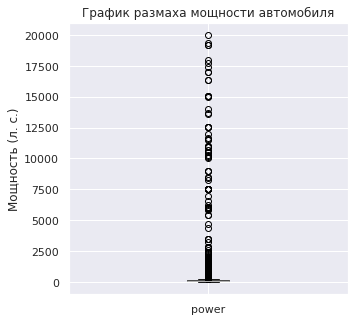

In [43]:
# Посмотрим на мощность ТС     
print(unique_values(['power']))

#  Посмотрим на статистические данные столбца, которые дают представление о распределение значений
print(data['power'].describe())

# график размаха
data.boxplot(column = 'power', figsize=(5,5))
plt.title('График размаха мощности автомобиля')
plt.ylabel('Mощность (л. с.)')
plt.show()

Медианное значение не совпаадет со средним из-за огромного кол-ва выбивающихся значений, где мощность равна 0 л.с (25155 объявлений) или свыше 1000 л.с. (что огромная редкость для "стоковых" машин).

In [44]:
25155# Посмотрим верхнюю границу "уса"

quantiles = data['power'].quantile([0.25, 0.5, 0.75])
print('Верхняя граница "уса" мощности ТС: ', quantiles[0.75] + 1.5*(quantiles[0.75] - quantiles[0.25]), 'л.с.')

Верхняя граница "уса" мощности ТС:  255.0 л.с.


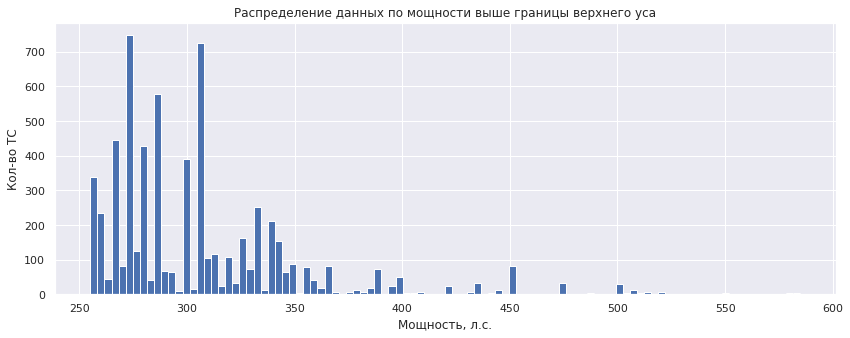

In [45]:
# проверим распределение данных выше границы верхнего уса
plt.figure(figsize=(14, 5)) 
data[(data['power'] > 254) & (data['power'] < 600)]['power'].hist(bins=100)
plt.title('Распределение данных по мощности выше границы верхнего уса')
plt.xlabel('Мощность, л.с.')
plt.ylabel('Кол-во ТС')
plt.show()

Большая часть ТС с мощность выше правого уса распределены до 370 л.с, есть серия автомобилей и большей мощности, которые можно выделить по кол-ву объявлений. Распределение не вызывает вопросов.

Посмотрим на оставшиеся машины и авто слабее 50 л.с.

In [46]:
# Посмотрим
# выше 500
print('Кол-во ТС с мощностью свыше 500 л.с.:', data[data['power'] > 500]['power'].value_counts().sum())
print('')
# меньше 10, т.к. до 20 л.с. у нас есть электромобили, но не равных 0 (таких у нас почти 36 тыс)
print('Кол-во ТС с мощностью меньше 10 л.с.:', data[(data['power'] < 10) & (data['power'] != 0)]['power'].value_counts().sum())

Кол-во ТС с мощностью свыше 500 л.с.: 343

Кол-во ТС с мощностью меньше 10 л.с.: 187


Удалим такие значений

In [47]:
data = data.loc[(data['power'] < 500) & (data['power'] > 10)]
data.shape

(278496, 10)

Посмотрим на столбец "тип топлива"

Значения столбца  fuel_type и кол-во уникальных значений 7

petrol      173473
gasoline     86979
NaN          12659
lpg           4587
cng            466
hybrid         200
other           72
electric        60
Name: fuel_type, dtype: int64

None


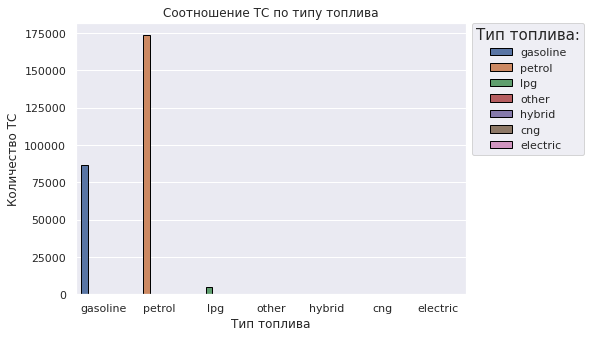

In [49]:
# Посмотрим на тип топлива     
print(unique_values(['fuel_type']))

# Посмотрим на столбчатый график 
sns.set(rc={'figure.figsize':(7,5)})
sns.countplot(data=data, x='fuel_type', ec='black', hue='fuel_type')
#plt.yticks(ticks=np.arange(0,5501,500))
plt.title('Соотношение ТС по типу топлива')
plt.xlabel('Тип топлива')
plt.ylabel('Количество ТС')
legend = plt.legend(title = "Тип топлива:",
                      title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

Около 2/3 объвлений - автомобили на бензине ('petrol') и примерно 1/3 - на дизели ('gasoline'); 'lpg' и 'cng' - машины на газу, в совокупности не более 5 000 объявлений; гибридных ТС ('hybrid') - 200 шт; электроавтомобилей ('electric') - 60; "остальные" еще 72 шт. В 12 тыс объявлений данный параметр не заполнен, попробуем восстановить его.

In [50]:
# для общей картины посмотрим распределение по типу топлива взависимости от года, модели и мощности
(data.pivot_table(index=['registration_year', 'model', 'power'], columns='fuel_type', aggfunc={'fuel_type': 'count'})).reset_index()

registration_year   model power fuel_type                           \
fuel_type                                       cng electric gasoline hybrid   
0                      1970     500    17       NaN      NaN      NaN    NaN   
1                      1970     500    18       NaN      NaN      NaN    NaN   
2                      1970     500    23       NaN      NaN      NaN    NaN   
3                      1970     601    23       NaN      NaN      NaN    NaN   
4                      1970     601    26       NaN      NaN      NaN    NaN   
...                     ...     ...   ...       ...      ...      ...    ...   
32305                  2016  zafira   150       NaN      NaN      3.0    NaN   
32306                  2016  zafira   116       NaN      NaN      NaN    NaN   
32307                  2016  zafira    94       1.0      NaN      NaN    NaN   
32308                  2016  zafira   147       NaN      NaN      NaN    NaN   
32309                  2016  zafira   149       NaN      NaN      NaN    NaN   

                            
fuel_type lpg other petrol  
0         NaN   NaN    1.0  
1         NaN   NaN    7.0  
2         NaN   NaN    1.0  
3         NaN   1.0    NaN  
4         NaN   NaN    1.0  
...        ..   ...    ...  
32305     NaN   NaN    NaN  
32306     NaN   NaN    1.0  
32307     NaN   NaN    NaN  
32308     NaN   NaN    1.0  
32309     NaN   NaN    1.0  

[32310 rows x 10 columns]

In [51]:
# Заменим пропущенные значения на "unknown", сделали "заглушку"

data['fuel_type'] = data['fuel_type'].fillna('unknown')
print(data['fuel_type'].unique())
print('Пропуски: ', data['fuel_type'].isna().sum())

['gasoline' 'petrol' 'unknown' 'lpg' 'other' 'hybrid' 'cng' 'electric']
Пропуски:  0


int64


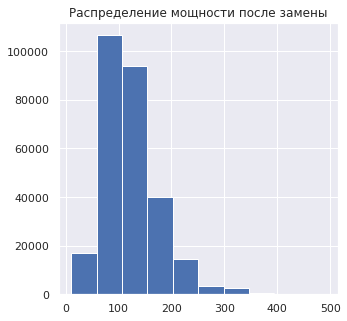

In [54]:
# Возвращаем тип данных для столбца
data['power'] = data['power'].astype('int64')
print(data['power'].dtypes)

# Посмотрим на распределение
data['power'].hist(figsize=(5,5))
plt.title('Распределение мощности после замены')
plt.show()

In [55]:
# Меняем "заглушку" у типа топлива по принципу замены у "мощности"

data['fuel_type'] = np.where(data['fuel_type'] == "unknown",
            (data.groupby(['model', 'power', 'registration_year'])['fuel_type'].transform(lambda x: x.value_counts().idxmax())), data['fuel_type'])

In [56]:
data['fuel_type'].value_counts(ascending=False, dropna=False)

petrol      181007
gasoline     89255
lpg           4631
unknown       2786
cng            483
hybrid         201
other           73
electric        60
Name: fuel_type, dtype: int64

In [57]:
# Посмотрим на эти 3,6 тыс unknown
data[data['fuel_type'] == "unknown"]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
52,1400,NaN,2016,manual,55,other,5000,unknown,hyundai,NaN
143,1500,wagon,1996,manual,126,a4,150000,unknown,audi,no
186,14000,sedan,2008,NaN,235,unidentified,150000,unknown,bmw,no
249,8000,sedan,2006,manual,177,impreza,150000,unknown,subaru,no
393,6250,NaN,2016,manual,310,astra,150000,unknown,opel,NaN
...,...,...,...,...,...,...,...,...,...,...
353626,1199,NaN,2016,manual,125,a4,150000,unknown,audi,no
353765,650,NaN,2000,manual,150,unidentified,150000,unknown,audi,no
354232,1799,wagon,2005,manual,180,signum,150000,unknown,opel,yes
354323,2999,wagon,2004,manual,234,vectra,100000,unknown,opel,NaN


In [58]:
# посмотрим на примере альфа-ромео есть ли зависимость типа топлива без года выпуска
data[(data['model'] == "159") & (data['power'] == 150)].head(30)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
893,5500,sedan,2006,manual,150,159,150000,gasoline,alfa_romeo,no
2528,7250,wagon,2007,manual,150,159,150000,gasoline,alfa_romeo,no
2899,4500,wagon,2007,auto,150,159,150000,gasoline,alfa_romeo,no
8875,7800,wagon,2007,manual,150,159,150000,gasoline,alfa_romeo,no
11900,7300,wagon,2007,manual,150,159,125000,gasoline,alfa_romeo,no
15706,2500,sedan,2006,manual,150,159,150000,gasoline,alfa_romeo,NaN
16692,4900,wagon,2006,manual,150,159,150000,gasoline,alfa_romeo,no
17462,5500,wagon,2006,manual,150,159,150000,gasoline,alfa_romeo,no
21494,6500,sedan,2005,manual,150,159,150000,gasoline,alfa_romeo,NaN
24343,7800,wagon,2007,manual,150,159,150000,gasoline,alfa_romeo,no


Заменим оставшиеся значения по принципу модели автомобиля и кол-ву л.с., не отталкиваясь от года выпуска. Хотя ошибок нам не избежать, бывают и дизельный, и бензиновый двигатель с одинаковым количеством "лошадок". При этом, как мы видим, и сами владельцы объявлений ошибаются: у нас есть объявление альфа-ромео "159" со 150 сильным мотором, который является дизельным, а в одном из объявлений стоит "бензин". От ошибок никуда не уйти.

In [59]:
data['fuel_type'] = np.where(data['fuel_type'] == "unknown",
                (data.groupby(['model', 'power'])['fuel_type'].transform(lambda x: x.value_counts().idxmax())), data['fuel_type'])

data.loc[(data['model'] == "159") & (data['power'] == 150) & (data['fuel_type'] == 'petrol'), 'fuel_type'] = 'gasoline'

print(data[data['fuel_type'] == "unknown"].shape)
data['fuel_type'].value_counts(ascending=False, dropna=False)

(374, 10)


petrol      182916
gasoline     89745
lpg           4642
cng            485
unknown        374
hybrid         201
other           73
electric        60
Name: fuel_type, dtype: int64

In [60]:
# оставшиеся модели заменим только по модели ТС
data['fuel_type'] = np.where(data['fuel_type'] == "unknown",
                (data.groupby('model')['fuel_type'].transform(lambda x: x.value_counts().idxmax())), data['fuel_type'])

data['fuel_type'].unique()

array(['gasoline', 'petrol', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Значения столбца  gearbox и кол-во уникальных значений 2

manual    216506
auto       57520
NaN         4470
Name: gearbox, dtype: int64

None


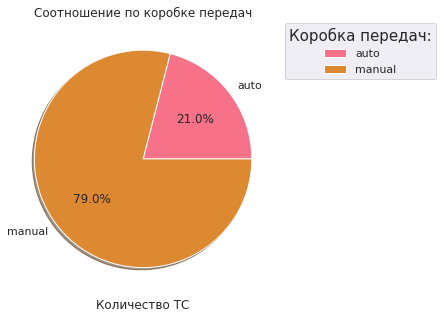

In [61]:
# Посмотрим на коробку передач

print(unique_values(['gearbox']))

# Посмотрим на круговую диаграмму
colors = sns.color_palette("husl", 10)
data.groupby(['gearbox']).count().plot(kind='pie', y='price', figsize=(5, 5),
  autopct='%0.01f%%', colors=colors, shadow=True)
plt.title('Соотношение по коробке передач')
plt.xlabel('Количество ТС')
plt.ylabel('')
legend = plt.legend(title = "Коробка передач:",
                     title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

80% автомобилей на механике, 20% на автомате и в довесок 4470 пропущенных значений. Заменим их по частоте встречаемости у определенной модели с N л.с.

In [62]:
data['gearbox'] = data['gearbox'].fillna('unknown')
data['gearbox'] = np.where(data['gearbox'] == "unknown",
            (data.groupby(['model', 'power'])['gearbox'].transform(lambda x: x.value_counts().idxmax())), data['gearbox'])

data['gearbox'].value_counts(ascending=False, dropna=False)

manual     219901
auto        58493
unknown       102
Name: gearbox, dtype: int64

In [63]:
# дальше по старой схеме
data['gearbox'] = np.where(data['gearbox'] == "unknown",
            (data.groupby('model')['gearbox'].transform(lambda x: x.value_counts().idxmax())), data['gearbox'])

data['gearbox'].value_counts(ascending=False, dropna=False)

manual    219993
auto       58503
Name: gearbox, dtype: int64

Значения столбца  vehicle_type и кол-во уникальных значений 8

sedan          79593
small          62420
wagon          56882
bus            25834
convertible    18451
coupe          13835
suv            10845
NaN             8431
other           2205
Name: vehicle_type, dtype: int64

None


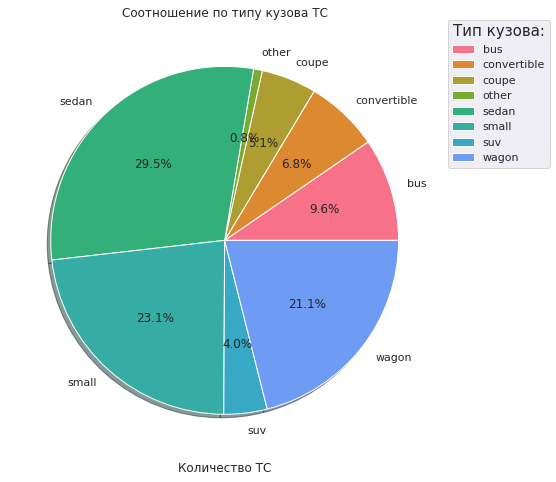

In [64]:
# Тип кузова

print(unique_values(['vehicle_type']))

# Посмотрим на круговую диаграмму
colors = sns.color_palette("husl", 10)
data.groupby(['vehicle_type']).count().plot(kind='pie', y='price', figsize=(8, 8),
  autopct='%0.01f%%', colors=colors, shadow=True)
plt.title('Соотношение по типу кузова ТС')
plt.xlabel('Количество ТС')
plt.ylabel('')
legend = plt.legend(title = "Тип кузова:",
                     title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

Тройка популярных типов кузова: седан, хэтчбек и универсал, все стандартно для Европы. Пропущенные значения, заменим по самому популярному кузову для каждой модели

In [65]:
data['vehicle_type'] = data['vehicle_type'].fillna(data.groupby('model')['vehicle_type'].transform(lambda x: x.value_counts().idxmax()))
unique_values(['vehicle_type'])

Значения столбца  vehicle_type и кол-во уникальных значений 8

sedan          84413
small          64054
wagon          57757
bus            26642
convertible    18556
coupe          13937
suv            10931
other           2206
Name: vehicle_type, dtype: int64



In [66]:
data.isna().sum()

price                    0
vehicle_type             0
registration_year        0
gearbox                  0
power                    0
model                    0
kilometer                0
fuel_type                0
brand                    0
repaired             36608
dtype: int64

Остался столбец "была машина в ремонте или нет". Так как правильной информации мы не сможем добыть, и не знаем, правда владелец забыл указать данные или умышленно не заполнил, то пропущенные значения превратим в "unknown".

In [67]:
data['repaired'] = data['repaired'].fillna('unknown')

In [68]:
data.reset_index(drop= True , inplace= True)

In [69]:
# Посмотрим кол-во дубликатов
print('Кол-во дубликатов', data.duplicated().sum())

data[data.duplicated()].sort_values(by='price', ascending=False).head(10)

Кол-во дубликатов 39827


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
180739,20000,coupe,2009,auto,224,other,150000,gasoline,mercedes_benz,no
91121,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
84732,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
267855,20000,coupe,2014,manual,160,cc,40000,petrol,volkswagen,no
240371,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
65969,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
264669,20000,sedan,2014,auto,184,leon,40000,gasoline,seat,no
45478,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
159790,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
171402,20000,coupe,2011,manual,170,a5,125000,petrol,audi,no


Ого! возникло более 40 тыс дубликатов, вот и "восстановили" данные...

Ценности для модели такие наблюдения уже не принесут - удаляем.

In [70]:
# Удалим явные дубликаты
data = data.drop_duplicates().reset_index(drop=True)

data.duplicated().sum()

0

In [71]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238669 entries, 0 to 238668
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              238669 non-null  int64 
 1   vehicle_type       238669 non-null  object
 2   registration_year  238669 non-null  int64 
 3   gearbox            238669 non-null  object
 4   power              238669 non-null  int64 
 5   model              238669 non-null  object
 6   kilometer          238669 non-null  int64 
 7   fuel_type          238669 non-null  object
 8   brand              238669 non-null  object
 9   repaired           238669 non-null  object
dtypes: int64(4), object(6)
memory usage: 18.2+ MB
None


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,18300,coupe,2011,manual,190,unidentified,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Уменьшили нашу выборку до 238669 строк, заменили тип данных. Избавились от выбросов и заменили некорректные данные. Удалили столбцы, которые не дадут модели никаких плюсов, даже могут запутать.

,price,registration_year,power,kilometer
price,1.000000,0.504215,0.479535,-0.381229
registration_year,0.504215,1.000000,0.091338,-0.319153
power,0.479535,0.091338,1.000000,0.146177
kilometer,-0.381229,-0.319153,0.146177,1.000000


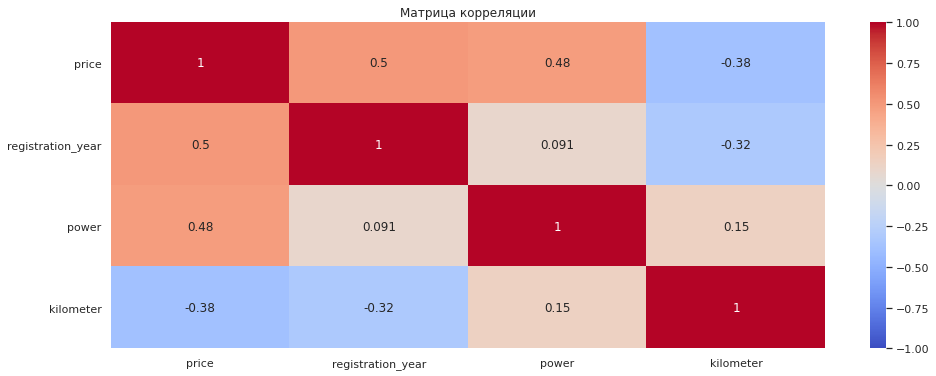

In [72]:
# Воспользуемся методом корреляции и хитмепом для наблюдения зависимостей

# выводим матрицу корреляции, без параметра индекса
corr_matrix = data.corr() #.drop(['postal_code'], axis = 1).corr()
display(corr_matrix)

# Визуализируем
plt.figure(figsize = (16, 6))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.title('Матрица корреляции')
plt.show()

Хитмеп нам показывает прямолинейную корреляцию наших параметров с целевым признаком:
 - Для года регистрации и мощности ТС - хорошая положительная зависимость, чем актуальнее год или больше мощность, тем больше и цена;
 - Для пробега - отрицательная, чем меньше пробег, тем выше цена.

## Обучение моделей

### Подготовим выборки для обучения моделей.

Одними из моделей обучения будут **CatBoost** и **LGBM** (Остальные модели рассмотрим далее). CatBoost позволяет использовать категориальные признаки без необходимости их предварительно обрабатывать. Даже говорится, что из "коробки" реультаты кодирования лучше.

In [73]:
# преобразуем тип данных для градации пробегов 
data['kilometer'] = data['kilometer'].astype(str)
data.dtypes

price                 int64
vehicle_type         object
registration_year     int64
gearbox              object
power                 int64
model                object
kilometer            object
fuel_type            object
brand                object
repaired             object
dtype: object

In [74]:
# создадим для нее копию
cat_data = deepcopy(data)

Для остальных моделей с помощью техники прямого кодирования или отображения (англ. **One-Hot Encoding, OHE**), или методом максимального правдоподобия (**M-estimate**) преобразуем категориальные признаки в численные.
- M-estimate для бренда и модели, т.к. у нас огромное кол-во значений (что бы не создавать новые столбцы);
- ОНЕ для остальных категориальных признаков

In [75]:
# сделаем список категориальных признаков
category_features = data.select_dtypes(include='object').columns.to_list()
category_features.remove('model')
category_features.remove('brand')
print(f'Категориальные признаки: {category_features}')

# сделаем список численных признаков
numeric_features = data.select_dtypes(include='int64').columns.to_list()
print(f'Численные признаки: {numeric_features}')

Категориальные признаки: ['vehicle_type', 'gearbox', 'kilometer', 'fuel_type', 'repaired']
Численные признаки: ['price', 'registration_year', 'power']


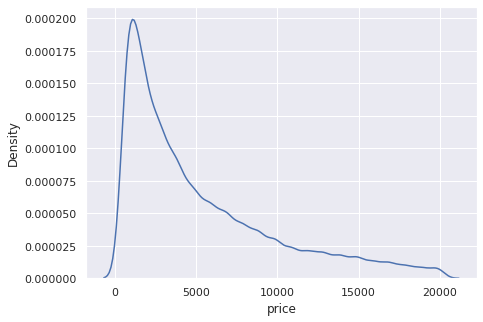

In [77]:
# Объявим переменные признака и цели
features = data.drop(['price'], axis=1) #  признаки для обущающей модели
target = data['price'] # целевой признак

# Посмотри на распределение целевого признака, что бы в дальнейшем понимать допустили ли мы ощибку и насколько она критична
sns.kdeplot(target)
plt.show()

С помощью функции train_test_split (от англ. «разделить на обучающую и тестовую») разобьем датасет на обучающую, валидационную и тестовую выборки. Спрятанной тестовой выборки нет. Исходные данные разделим в соотношении 3:1:1

In [78]:
#  Обучающая выборка
# В размер валидационной выборки (test_size) мы пишем 0,4 (выражается в долях — от 0 до 1), т.к. 
# соотношении 3:1:1 и на валидационная и тестовая выборку отправляем 40% исходных данных

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

# Смотрим размер выборки 
print(features_train.shape)
print(target_train.shape)

(143201, 9)
(143201,)


In [79]:
#  Валидационная и тестовая выборки
# test_size = 0.5, выборки делим пополам

features_test, features_valid, target_test, target_valid = train_test_split(
    features_test, target_test, test_size=0.5, random_state=12345)

# Смотрим размер выборки 
print('Размер валидационной выборки:\n', features_valid.shape, '\n', target_valid.shape)
print('')
print('Размер тестовой  выборки:\n', features_test.shape, '\n', target_test.shape)

Размер валидационной выборки:
 (47734, 9) 
 (47734,)

Размер тестовой  выборки:
 (47734, 9) 
 (47734,)


Повторим все это для CatBoost выборки

In [80]:
# Объявим переменные признака и цели
features_cat = cat_data.drop(['price'], axis=1) #  признаки для обущающей модели
target_cat = cat_data['price'] # целевой признак

In [81]:
#  Обучающая выборка
cat_features_train, cat_features_test, cat_target_train, cat_target_test = train_test_split(
    features_cat, target_cat, test_size=0.4, random_state=12345)

print(cat_features_train.shape)
print(cat_target_train.shape)

(143201, 9)
(143201,)


In [82]:
#  Валидационная и тестовая выборки

cat_features_test, cat_features_valid, cat_target_test, cat_target_valid = train_test_split(
    cat_features_test, cat_target_test, test_size=0.5, random_state=12345)

# Смотрим размер выборки 
print('Размер валидационной выборки:\n', cat_features_valid.shape, '\n', cat_target_valid.shape)
print('')
print('Размер тестовой  выборки:\n', cat_features_test.shape, '\n', cat_target_test.shape)

Размер валидационной выборки:
 (47734, 9) 
 (47734,)

Размер тестовой  выборки:
 (47734, 9) 
 (47734,)


Мы с вами разбили данные на обучающую, валидационную и тестовую выборки. На обучение ушло 143202 записей, на валидационную и тестовую по 47734 записи для каждой выборки соответсвенно.

In [85]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False).fit(features_train[category_features])

features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[category_features])

features_train = features_train.drop(category_features, axis=1)

features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[category_features])

features_valid = features_valid.drop(category_features, axis=1)

features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[category_features])

features_test = features_test.drop(category_features, axis=1)

# смотрим на результат
display(features_train.head())
display(features_valid.head())

,registration_year,power,model,brand,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,kilometer_80000,kilometer_90000,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,repaired_unknown,repaired_yes
171626,2005,320,x_reihe,bmw,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
183680,1997,170,unidentified,bmw,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
165741,1996,150,5er,bmw,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
33046,1992,125,unidentified,honda,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
148444,1997,125,passat,volkswagen,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


,registration_year,power,model,brand,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,kilometer_80000,kilometer_90000,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,repaired_unknown,repaired_yes
148834,2005,105,octavia,skoda,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
180999,1976,34,kaefer,volkswagen,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
219403,2014,122,yeti,skoda,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
71847,2005,155,mondeo,ford,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
69651,2009,177,x_reihe,bmw,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
# кодируем бренд и модель

# Обучаем на обучающем наборе
encoder = MEstimateEncoder(cols=['brand','model'], handle_unknown='value', handle_missing = 'value').fit(features_train, target_train) 

# Конвертировать обучающий набор
features_train = encoder.transform(features_train) 
# Конвертировать валидационный набор
features_valid = encoder.transform(features_valid) 
# Конвертировать тестовый набор
features_test = encoder.transform(features_test)

# handle_unknown и handle_missing установлены в "значение"
# В целевом коде handle_unknown и handle_missing принимают только настройки «error», «return_nan» и «value»
# По умолчанию оба значения - «значение», то есть среднее значение зависимой переменной
# в обучающем наборе для неизвестных категорий или отсутствующих значений.

features_train.head()

,registration_year,power,model,brand,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,kilometer_80000,kilometer_90000,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,repaired_unknown,repaired_yes
171626,2005,320,12350.878484,6915.739451,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
183680,1997,170,4121.425094,6915.739451,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
165741,1996,150,6815.578895,6915.739451,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
33046,1992,125,4121.425094,4279.919607,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
148444,1997,125,5087.970638,5340.144143,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


Деревья решений и алгоритмы основанные на них (случайный лес, градиентный бустинг) не зависят от масштаба признаков, поэтому масштабирование не сделает хуже таким моделям, а для линейных - стандартизация в нашейм случае необходима.

In [89]:
# Масштабируем признаки с помощью стандартизация данных.

# Чтобы не появлялось предупреждение SettingWithCopy добавим в код строчку:
pd.options.mode.chained_assignment = None

# выбираем столбцы с количественными данными для масштабирования
numeric = ['brand', 'model', 'registration_year', 'power'] #, 'postal_code', 'kilometer' 

# Создадим объект StandardScaler (структура для стандартизации данных)  и настроим его на обучающих данных. 
# Настройка — это вычисление среднего и дисперсии
scaler = StandardScaler()
scaler.fit(features_train[numeric])

# Преобразуем обучающую и валидационную выборки функцией transform().
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# смотрим
display(features_train.head())

,registration_year,power,model,brand,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,kilometer_80000,kilometer_90000,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,repaired_unknown,repaired_yes
171626,0.278936,3.660696,2.992621,1.153203,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
183680,-0.999413,0.857498,-0.467729,1.153203,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
165741,-1.159206,0.483738,0.665118,1.153203,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
33046,-1.798381,0.016538,-0.467729,-0.655901,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
148444,-0.999413,0.016538,-0.061313,0.071788,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


Итак: 
- Разделили датафрейм на обучающую, валидационную и тестовую выборки
- Преобразовали категориальные признаки с помощью методов: One-Hot Encoding и M-estimate.
- С помощью StandardScaler стандартизировали данные

### Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.

В качестве моделей буем рассматривать:

**Решающее дерево (Decision Tree Regressor)** - это структура данных для регрессии деревом решений.. Импортируем её из библиотеки: `from sklearn.tree import DecisionTreeRegressor`

**Линейная регрессия (Linear Regression)** - применяется для прогнозирования вероятности возникновения некоторого события по значениям множества признаков. Модель LinearRegression лежит в модуле sklearn.linear_model (от англ. «линейная модель») библиотеки sklearn. Импортируем его: `from sklearn.linear_model import LinearRegression`

**Ридж-регрессия (Ridge)** — это метод, который мы можем использовать для подбора модели регрессии, когда в данных присутствует мультиколлинеарность(применяют для борьбы с переизбыточностью данных, когда независимые переменные коррелируют друг с другом). Хоть в наших данных мультиколлинеарность не выявлена, модель будем использовать в качесте сравнения. Испортируем: `from sklearn. linear_model import Ridge`

**CatBoost** - это алгоритм для повышения градиента на деревьях решений. Использует небрежные (oblivious) деревья решений, чтобы вырастить сбалансированное дерево. Одни и те же функции используются для создания левых и правых разделений (split) на каждом уровне дерева. Импортируем: `from catboost import CatBoostRegressor`

**LightGBM** - предоставляет реализацию деревьев принятия решений с градиентным бустингом. Известен своей более высокой скоростью обучения, хорошей точностью с параметрами по умолчанию, параллельным и GPU обучением, малым использованием памяти и возможностью обработки больших датасетов, которые не всегда помещаются в ней. Импортируем: `from lightgbm import LGBMRegressor`

In [90]:
# Создадим таблицу результатов, куда будем заносить интересующие нас результаты
table = PrettyTable()
table.field_names = ['model', 'fit_time', 'predict_time','RMSE']
print(table)

+-------+----------+--------------+------+
| model | fit_time | predict_time | RMSE |
+-------+----------+--------------+------+
+-------+----------+--------------+------+


**Линейная регрессия (LinearRegression)**

In [91]:
%%time

lr = LinearRegression() # инициализируем модель
lr.fit(features_train, target_train) #обучим модель на тренировочной выборке

CPU times: user 307 ms, sys: 257 ms, total: 564 ms
Wall time: 541 ms


LinearRegression()

In [92]:
%%time
lr_predicted = lr.predict(features_valid) # получим предсказания модели на валидационной выборке

CPU times: user 41.5 ms, sys: 36.8 ms, total: 78.3 ms
Wall time: 103 ms


Метрика качетсва - **RMSE (Корень из среднеквадратичной ошибки)** представляет собой показатель, указывающий нам среднее расстояние между прогнозируемыми значениями из модели и фактическими значениями в наборе данных. Чем ниже RMSE, тем лучше данная модель может «соответствовать» набору данных.

In [93]:
# сделаем функцию для подсчета RMSE
def rmse(x_valid, y_predicted):
    return mean_squared_error(x_valid, y_predicted, squared=False)

In [94]:
#  Посчитаем значение метрики на валидационной выборке
rmse_lr = rmse(target_valid, lr_predicted)
print(f'Лучшее значение RMSE для Линейной регрессии: {rmse_lr}')

Лучшее значение RMSE для Линейной регрессии: 2700.410656128897


In [95]:
# Вносим данные в таблицу
table.add_row(['Linear Regression', '478 ms', '8.51 ms', rmse_lr])
print(table)

+-------------------+----------+--------------+-------------------+
|       model       | fit_time | predict_time |        RMSE       |
+-------------------+----------+--------------+-------------------+
| Linear Regression |  478 ms  |   8.51 ms    | 2700.410656128897 |
+-------------------+----------+--------------+-------------------+


**Ридж-регрессия (Ridge)**

In [96]:
%%time

solvers = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
best_model = None
best_rmse = 2900

for solver_ridge in solvers:
    for alpha_ridge in range(1, 5, 1):
        rd = Ridge(random_state=STATE, alpha=alpha_ridge, solver=solver_ridge).fit(features_train, target_train)
        rd_predicted = rd.predict(features_valid)
        rmse_rd = rmse(target_valid, rd_predicted)
        print(f"solver = {solver_ridge}, alpha = {alpha_ridge}, rmse={rmse_rd}")
        if rmse_rd <= best_rmse:
            best_alpha = alpha_ridge
            best_solver = solver_ridge
            best_model = rd
            best_rmse = rmse_rd

solver = svd, alpha = 1, rmse=2700.4080160783064
solver = svd, alpha = 2, rmse=2700.4145072093424
solver = svd, alpha = 3, rmse=2700.4288264774377
solver = svd, alpha = 4, rmse=2700.44985477801
solver = cholesky, alpha = 1, rmse=2700.4080160783055
solver = cholesky, alpha = 2, rmse=2700.4145072093424
solver = cholesky, alpha = 3, rmse=2700.4288264774377
solver = cholesky, alpha = 4, rmse=2700.449854778011
solver = lsqr, alpha = 1, rmse=2700.4730688257105
solver = lsqr, alpha = 2, rmse=2700.4788206643157
solver = lsqr, alpha = 3, rmse=2700.4921870083945
solver = lsqr, alpha = 4, rmse=2700.512100078829
solver = sparse_cg, alpha = 1, rmse=2700.4038145514255
solver = sparse_cg, alpha = 2, rmse=2700.4143719268727
solver = sparse_cg, alpha = 3, rmse=2700.427214949853
solver = sparse_cg, alpha = 4, rmse=2700.454430504901
solver = sag, alpha = 1, rmse=2700.4074150640545
solver = sag, alpha = 2, rmse=2700.4162480374453
solver = sag, alpha = 3, rmse=2700.430696445423
solver = sag, alpha = 4, rms

In [98]:
rd_best_rmse = best_rmse    
print('')
print(f"Лучшее значение rmse {rd_best_rmse}, при solver = {best_solver}, и значение alpha = {best_alpha}")


Лучшее значение rmse 2700.4038145514255, при solver = sparse_cg, и значение alpha = 1


In [99]:
%%time

# обучим на лучших гиперпараметрах
rd = Ridge(random_state=STATE, alpha=best_alpha, solver=best_solver).fit(features_train, target_train)

CPU times: user 284 ms, sys: 296 ms, total: 580 ms
Wall time: 535 ms


In [100]:
%%time

# получим предсказания модели на валидационной выборке
rd_predicted = rd.predict(features_valid)

CPU times: user 11.9 ms, sys: 26.2 ms, total: 38.1 ms
Wall time: 17.2 ms


In [101]:
#  Посчитаем значение метрики на валидационной выборке
rmse_rd = rmse(target_valid, rd_predicted)
print(f'Лучшее значение RMSE для Ридж-регрессии: {rmse_rd}')

Лучшее значение RMSE для Ридж-регрессии: 2700.4038145514255


In [102]:
# Вносим данные в таблицу
table.add_row(['Ridge', '12.7 s', '8.91 ms', rmse_rd])
print(table)

+-------------------+----------+--------------+--------------------+
|       model       | fit_time | predict_time |        RMSE        |
+-------------------+----------+--------------+--------------------+
| Linear Regression |  478 ms  |   8.51 ms    | 2700.410656128897  |
|       Ridge       |  12.7 s  |   8.91 ms    | 2700.4038145514255 |
+-------------------+----------+--------------+--------------------+


**Decision Tree Regressor**

In [103]:
%%time
# подбирем лучшие гиперпараметры

best_model = None
best_rmse = 2900 # на Линейной регрессии значение равно ~2803. Поставим для ориентира чуть хуже

for depth in range(1, 16, 1):
    for leaf in range(1, 4, 1):
        tree = DecisionTreeRegressor(random_state=STATE, max_depth=depth, min_samples_leaf=leaf) # обучим модель с заданной глубиной дерева
        tree.fit(features_train, target_train) # обучим модель
        tree_predicted = tree.predict(features_valid)
        rmse_tree = rmse(target_valid, tree_predicted) # рассчитаем метрику качества
        print(f" max_depth = {depth}, rsme = {rmse_tree}, min_samples_leaf={leaf}")
        #print(f"rsme = {rmse_tree}")
        if rmse_tree <= best_rmse:
            best_leaf = leaf
            best_depth = depth # сохраним наилучшее показание глубины дерева
            best_model = tree # сохраним наилучшую модель
            best_rmse = rmse_tree # сохраним наилучшее значение rsme

 max_depth = 1, rsme = 3702.6986717776804, min_samples_leaf=1
 max_depth = 1, rsme = 3702.6986717776804, min_samples_leaf=2
 max_depth = 1, rsme = 3702.6986717776804, min_samples_leaf=3
 max_depth = 2, rsme = 3236.87600742119, min_samples_leaf=1
 max_depth = 2, rsme = 3236.87600742119, min_samples_leaf=2
 max_depth = 2, rsme = 3236.87600742119, min_samples_leaf=3
 max_depth = 3, rsme = 2982.6018046707845, min_samples_leaf=1
 max_depth = 3, rsme = 2982.6018046707845, min_samples_leaf=2
 max_depth = 3, rsme = 2982.6018046707845, min_samples_leaf=3
 max_depth = 4, rsme = 2633.1276524124974, min_samples_leaf=1
 max_depth = 4, rsme = 2633.1276524124974, min_samples_leaf=2
 max_depth = 4, rsme = 2633.1276524124974, min_samples_leaf=3
 max_depth = 5, rsme = 2427.8185506154505, min_samples_leaf=1
 max_depth = 5, rsme = 2427.8185506154505, min_samples_leaf=2
 max_depth = 5, rsme = 2427.8185506154505, min_samples_leaf=3
 max_depth = 6, rsme = 2277.6368894357433, min_samples_leaf=1
 max_depth = 6

In [104]:
tree_best_rmse = best_rmse    
print('')
print(f"Лучшее значение rmse {tree_best_rmse}, при глубине {best_depth}, и минимальном кол-ве листьев {best_leaf}")


Лучшее значение rmse 1817.730132247624, при глубине 15, и минимальном кол-ве листьев 3


In [105]:
%%time

# используем лучшую глубину для расчета времени
tree = DecisionTreeRegressor(random_state=STATE, max_depth=15, min_samples_leaf = 3).fit(features_train, target_train)

CPU times: user 783 ms, sys: 2.4 ms, total: 786 ms
Wall time: 816 ms


In [106]:
%%time

# получим предсказания модели на валидационной выборке
tree_predicted = tree.predict(features_valid)

CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 14.3 ms


In [107]:
#  Посчитаем значение метрики на валидационной выборке
rmse_tree = rmse(target_valid, tree_predicted)
print(f'Лучшее значение RMSE для Decision Tree Regressor: {rmse_tree}')

Лучшее значение RMSE для Decision Tree Regressor: 1817.1555674370816


In [108]:
# Вносим данные в таблицу
table.add_row(['Decision Tree Regressor', '588 ms', '12.8 ms', rmse_tree])
print(table)

+-------------------------+----------+--------------+--------------------+
|          model          | fit_time | predict_time |        RMSE        |
+-------------------------+----------+--------------+--------------------+
|    Linear Regression    |  478 ms  |   8.51 ms    | 2700.410656128897  |
|          Ridge          |  12.7 s  |   8.91 ms    | 2700.4038145514255 |
| Decision Tree Regressor |  588 ms  |   12.8 ms    | 1817.1555674370816 |
+-------------------------+----------+--------------+--------------------+


**CatBoostRegressor**

In [109]:
# вспомним категариальные признаки
cat_features = cat_data.select_dtypes(include='object').columns.to_list()
cat_features

['vehicle_type',
 'gearbox',
 'model',
 'kilometer',
 'fuel_type',
 'brand',
 'repaired']

In [110]:
%%time

cat = CatBoostRegressor(  # подбираем гиперпараметры
    iterations = 10000, # кол-во итераций
    learning_rate=0.1, # шаг обучения
    metric_period=200, # отображение результатов под графиком через какой шаг
    od_type='Iter', # детектор переобучения
    od_wait=50 # через сколько итераций сработает детектор
) 
cat.fit(
    cat_features_train, cat_target_train, # передаем обучающую выборку
    cat_features=cat_features, # передаем категориальные признаки
    eval_set=(cat_features_valid, cat_target_valid), # валидационная выборка
    plot=True # график
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4351.4459078	test: 4325.0061920	best: 4325.0061920 (0)	total: 404ms	remaining: 1h 7m 21s
200:	learn: 1668.3396311	test: 1688.2222921	best: 1688.2222921 (200)	total: 43.7s	remaining: 35m 28s
400:	learn: 1608.6770290	test: 1646.1415989	best: 1646.1415989 (400)	total: 1m 27s	remaining: 34m 54s
600:	learn: 1576.4113373	test: 1628.0284426	best: 1628.0284426 (600)	total: 2m 11s	remaining: 34m 18s
800:	learn: 1554.1627374	test: 1618.3314544	best: 1618.3314544 (800)	total: 2m 59s	remaining: 34m 19s
1000:	learn: 1534.5915338	test: 1609.6350042	best: 1609.6350042 (1000)	total: 3m 50s	remaining: 34m 29s
1200:	learn: 1519.3030930	test: 1603.6092956	best: 1603.5798551 (1198)	total: 4m 48s	remaining: 35m 12s
1400:	learn: 1505.6864080	test: 1599.2633046	best: 1599.2031378 (1393)	total: 5m 45s	remaining: 35m 23s
1600:	learn: 1493.4143368	test: 1595.8420605	best: 1595.8420605 (1600)	total: 6m 39s	remaining: 34m 57s
1800:	learn: 1482.3382205	test: 1593.1552980	best: 1593.0800586 (1794)	total: 

In [111]:
%%time

# получим предсказания модели на валидационной выборке
cat_predicted = cat.predict(cat_features_valid)

CPU times: user 3.01 s, sys: 12.5 ms, total: 3.02 s
Wall time: 3.08 s


In [112]:
#  Посчитаем значение метрики на валидационной выборке
rmse_cat = rmse(cat_target_valid, cat_predicted)
print(f'Лучшее значение RMSE для CatBoostRegressor: {rmse_cat}')

Лучшее значение RMSE для CatBoostRegressor: 1575.5426611032385


In [113]:
# Вносим данные в таблицу
table.add_row(['CatBoostRegressor', '7min 53s', '1.46 s', rmse_cat])
print(table)

+-------------------------+----------+--------------+--------------------+
|          model          | fit_time | predict_time |        RMSE        |
+-------------------------+----------+--------------+--------------------+
|    Linear Regression    |  478 ms  |   8.51 ms    | 2700.410656128897  |
|          Ridge          |  12.7 s  |   8.91 ms    | 2700.4038145514255 |
| Decision Tree Regressor |  588 ms  |   12.8 ms    | 1817.1555674370816 |
|    CatBoostRegressor    | 7min 53s |    1.46 s    | 1575.5426611032385 |
+-------------------------+----------+--------------+--------------------+


**LGBMRegressor**

In [114]:
# приводим значения категориальных параметров к категориальному типу данных
for feature in cat_features:
    cat_features_train[feature] = pd.Series(cat_features_train[feature], dtype="category")
    cat_features_valid[feature] = pd.Series(cat_features_valid[feature], dtype="category")
display(cat_features_train.dtypes)

vehicle_type         category
registration_year       int64
gearbox              category
power                   int64
model                category
kilometer            category
fuel_type            category
brand                category
repaired             category
dtype: object

In [115]:
%%time

lgbm = LGBMRegressor(
    learning_rate=0.1,
    num_leaves=100,
    random_state=STATE,
    categorical_features=cat_features,
    boosting_type='gbdt'                
)
lgbm.fit(
    cat_features_train, cat_target_train,
    eval_set = (cat_features_valid, cat_target_valid),
    verbose=False
)

CPU times: user 23min 39s, sys: 10.9 s, total: 23min 50s
Wall time: 23min 57s


LGBMRegressor(categorical_features=['vehicle_type', 'gearbox', 'model',
                                    'kilometer', 'fuel_type', 'brand',
                                    'repaired'],
              num_leaves=100,
              random_state=RandomState(MT19937) at 0x7F937985C340)

In [116]:
%%time

# получим предсказания модели на валидационной выборке
lgbm_predicted = lgbm.predict(cat_features_valid)

CPU times: user 870 ms, sys: 2.29 ms, total: 872 ms
Wall time: 930 ms


In [117]:
#  Посчитаем значение метрики на валидационной выборке
rmse_lgbm = rmse(cat_target_valid, lgbm_predicted)
print(f'Лучшее значение RMSE для LGBMRegressor: {rmse_lgbm}')

Лучшее значение RMSE для LGBMRegressor: 1576.581668301673


In [118]:
# Вносим данные в таблицу
table.add_row(['LGBMRegressor', '11.1 s', '785 ms', rmse_lgbm])
print(table)

+-------------------------+----------+--------------+--------------------+
|          model          | fit_time | predict_time |        RMSE        |
+-------------------------+----------+--------------+--------------------+
|    Linear Regression    |  478 ms  |   8.51 ms    | 2700.410656128897  |
|          Ridge          |  12.7 s  |   8.91 ms    | 2700.4038145514255 |
| Decision Tree Regressor |  588 ms  |   12.8 ms    | 1817.1555674370816 |
|    CatBoostRegressor    | 7min 53s |    1.46 s    | 1575.5426611032385 |
|      LGBMRegressor      |  11.1 s  |    785 ms    | 1576.581668301673  |
+-------------------------+----------+--------------+--------------------+


## Анализ моделей

### Проанализируем время обучения, время предсказания и качество моделей.

In [119]:
# Посмотрим на таблицу результатов
table

model,fit_time,predict_time,RMSE
Linear Regression,478 ms,8.51 ms,2700.410656128897
Ridge,12.7 s,8.91 ms,2700.4038145514255
Decision Tree Regressor,588 ms,12.8 ms,1817.1555674370816
CatBoostRegressor,7min 53s,1.46 s,1575.5426611032385
LGBMRegressor,11.1 s,785 ms,1576.581668301673


In [120]:
# Проверим модель на адекватность

ds = DummyRegressor(strategy='mean')
ds.fit(cat_features_train, cat_target_train)
ds_predicted=ds.predict(cat_features_valid)
rmse_ds = rmse(cat_target_valid, ds_predicted)
print(f'Лучшее значение RMSE для DummyRegressor: {rmse_ds}')

Лучшее значение RMSE для DummyRegressor: 4621.31359703956


Мы проанализировали результаты предсказаний на 5 моделях и получили следующие результаты:
- Линейные модели (Linear Regression, Ridge) - хорошее время обучение, не очень удовлетворительные результаты: ~2683
- Деревянная модель Decision Tree Regressor - отличное время обучение при лучших гиперпараметрах (глубина дерева = 14), результат намного лучше, чем у линейных моделей (RMSE ~ 1878).
- Лучшие результаты показали бустинговые модели CatBoostRegressor и LGBMRegressor. Результат метрики RMSE очень близки 1575 и 1567 соответственно. При этом выделим **LGBMRegressor** тем, что обучение более чем на 6 минуты быстрее, чем у CatBoost, тем самым посчитав **модель самой лучшей в нашем исследование**. Так же отметим эти две модели тем, что они сами обрабатывают категориальные признаки, на что исследователю не надо тратить время.

Проверили модель на адекватность. RMSE модели DummyRegressor (4627.811810665407) в разы хуже, чем RMSE, полученное на тестовом наборе данных. Это говорит нам о том, что модель машинного обучения лучше предсказывает, чем постоянная модели, предсказывающее среднее значение.

### Опираясь на критерии заказчика, выберем лучшую модель, проверив её качество на тестовой выборке.

In [121]:
# Объединим обучающую и валидационные выборки в надежде увеличить немного качество.

features_train_valid = pd.concat([cat_features_train, cat_features_valid])
target_train_valid = pd.concat([cat_target_train, cat_target_valid])

for feature in cat_features:
    features_train_valid[feature] = pd.Series(features_train_valid[feature], dtype="category")
    cat_features_test[feature] = pd.Series(cat_features_test[feature], dtype="category")

print(features_train_valid.shape)
print(target_train_valid.shape)

(190935, 9)
(190935,)


Проведем финальное тестирование. 

Так как лучшей моделью оказался "LGBMRegressor" со значением RSME 1583.847586423658, то тестовую выборку будем проводить на нем

In [122]:
%%time

lgbm = LGBMRegressor(
    learning_rate=0.1,
    num_leaves=100,
    random_state=STATE,
    categorical_features=cat_features,
    boosting_type='gbdt'                
)
lgbm.fit(
    features_train_valid, target_train_valid,
    eval_set = (cat_features_test, cat_target_test),
    verbose=False
)

CPU times: user 23min 23s, sys: 13.5 s, total: 23min 37s
Wall time: 23min 44s


LGBMRegressor(categorical_features=['vehicle_type', 'gearbox', 'model',
                                    'kilometer', 'fuel_type', 'brand',
                                    'repaired'],
              num_leaves=100,
              random_state=RandomState(MT19937) at 0x7F937985C340)

In [123]:
lgbm_predicted_final = lgbm.predict(cat_features_test)
rmse_lgbm_final = rmse(cat_target_test, lgbm_predicted_final)
print(f'Лучшее значение RMSE для LGBMRegressor по объединенной выборке: {rmse_lgbm_final}')

Лучшее значение RMSE для LGBMRegressor по объединенной выборке: 1573.340485994287


**Вывод:**

Мы разработали модель для определения рыночной стоимости своего транспортного средства для сервис по продаже автомобилей с пробегом «Не бит, не крашен». Данное приложение должно привлечь новых клиентов. 
С помощью данных о технических характеристиках, комплектациях и ценах других автомобилей мы построили модель, в которой смогли выявить лучшие критерии, которые важны заказчику. Такие результатов мы добились с помощью **LightGBM** — это фреймворк, который предоставляет реализацию деревьев принятия решений с градиентным бустингом:
- качество предсказания: Лучшее значение RMSE на тестовой выборке: ~ *1573.1*;
- время обучения модели: на обучающей выборке - *11.1 s*
- время предсказания модели: *785 ms*
- для тестовой выборки - время обучения и предсказания модели: 24.7 s

Таких данных добились благодаря тому, что изучили и проанализировали предоставленные данные, обработали информацию (заполнили пропущенные значения и обработали аномалии в столбцах, удалили дубликаты, изменили типы данных и т.д.). Посмотрели корреляцию. Построили несколько моделей для сравнения: линейные(Linear Regression, Ridge) и "деревянные" (Decision Tree Regressor). В них использовали кодировку данных с помощью техники прямого кодирования или отображения (англ. One-Hot Encoding, OHE) и методом максимального правдоподобия (M-estimate). Стандатизировали данные благодаря StandardScaler. Использовали бустинговые модели CatBoostRegressor и LGBMRegressor. Использовали различные гиперпараметры. Сделали разбивку данных на обучающую, валидационную и тестовую. Таким образом выполнили поставленную задачу добиться значение метрики RMSE меньше 2500 (у нас 1573).
